<a href="https://colab.research.google.com/github/NavaneethRaj17/Brain-Tumor-Classification/blob/initialize/brain_tumor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# Importing necessary libraries
import numpy as np
import tensorflow as tf #The core library for deep learning, with Sequential and layers modules for building and training the model.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator #For augmenting and loading images, helping to prevent overfitting by increasing data variability.
from tensorflow.keras.optimizers import Adam #A widely-used optimizer in deep learning for adaptive learning rates.
from tensorflow.keras.preprocessing import image #To load individual images for predictions or visualizations.
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix #For performance metrics, helping to evaluate model accuracy and detailed classification performance.
import pandas as pd
import numpy as np
from PIL import Image #For working with images directly.
import seaborn as sns
import matplotlib.pyplot as plt
import warnings #To ignore warnings during model training, which can often be expected but aren’t critical.
import zipfile
warnings.filterwarnings('ignore')


In [5]:
! pip install kaggle #kaggle package, which is commonly used to download datasets from Kaggle directly.

In [6]:
import os #setting up the Kaggle API configuration for a Google Colab environment.

os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
# API to fetch dataset from Kaggle

# Go to the respective kaggle dataset --> download datset --> download API Command
! kaggle datasets download sartajbhuvaji/brain-tumor-classification-mri

## Uploading dataset using API-->dataset uploaded in zip format

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
 96% 83.0M/86.8M [00:00<00:00, 207MB/s]
100% 86.8M/86.8M [00:00<00:00, 205MB/s]


In [11]:
# Extracting zipfiles
#extract the contents of the zip file located at /content/brain-tumor-classification-mri.zip into the /content/ directory.

zip_file_path = '/content/brain-tumor-classification-mri.zip'
extract_dir = '/content/'

with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
 zip_ref.extractall(extract_dir)




In [15]:
IMG_WIDTH, IMG_HEIGHT = 256, 256 #Dimensions to which each image will be resized (256x256 pixels).
TRAIN_DIR = '/content/Training'
TEST_DIR = '/content/Testing'
#Paths to the training and testing datasets.

BATCH_SIZE = 32 #Number of images passed through the model at once during training and evaluation
EPOCHS = 10 #Number of times the model will see the entire training dataset.
LEARNING_RATE = 0.001 #The initial step size used by the optimizer (0.001 for Adam is often a good starting point).



In [13]:
# data augmentation for the training images, which can help improve the model's generalization by creating slightly varied versions of each image
train_datagen = ImageDataGenerator(
    rescale=1./255, #Normalizes the pixel values to a range of 0–1, which is common for neural networks.
    shear_range=0.2, #Applies a shear transformation to the images, effectively "tilting" them.
    zoom_range=0.2, #Randomly zooms into images by up to 20%, making the model more resilient to scale variations.
    horizontal_flip=True #Randomly flips images horizontally, adding variety and helping the model learn spatial invariance.
)

test_datagen = ImageDataGenerator(rescale=1./255)
#applied rescaling with test_datagen to keep the images consistent without augmentation, which is standard practice for evaluating the model accuratel


In [16]:
#train_generator and test_generator with class_mode='categorical', which is appropriate for different types of brain tumor classifications

#one-hot encode the labels, making them suitable for a multi-class classification model.
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [19]:
#These lines create TensorFlow datasets for the training and testing directories, respectively.
#The datasets automatically handle loading and resizing images to (IMG_HEIGHT, IMG_WIDTH) with a specified batch size.

train_ds = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR,image_size=(IMG_HEIGHT, IMG_WIDTH),batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR,image_size=(IMG_HEIGHT, IMG_WIDTH),batch_size=BATCH_SIZE)


#retrieves the class names from the dataset, which TensorFlow infers based on the directory structure.
# Each subdirectory inside TRAIN_DIR and TEST_DIR is considered a separate class.


class_names = train_ds.class_names
class_names


Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.


['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [24]:
def show_images(dataset, title): #function, show_images, is designed to display a grid of images from a TensorFlow dataset, with labels as titles
 plt.figure(figsize = (6,6))
 for images, labels in dataset.take(1):
  for i in range(9):
   ax = plt.subplot(3,3,i+1)
   plt.imshow(images[i].numpy().astype('uint8'))
   plt.title(class_names[labels[i]])
   plt.axis("off")
 plt.suptitle(title)
 plt.show()


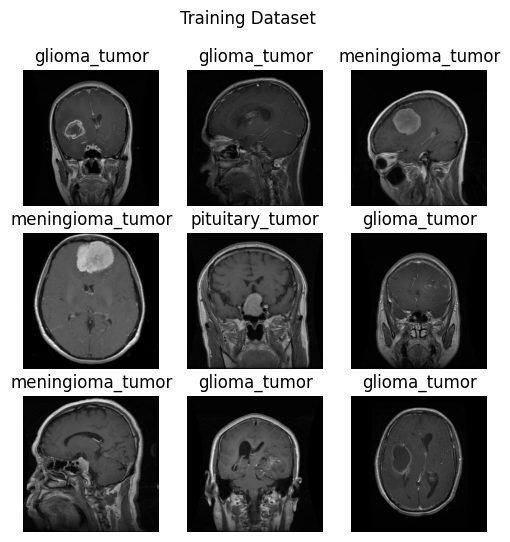

In [26]:
show_images(train_ds, "Training Dataset")

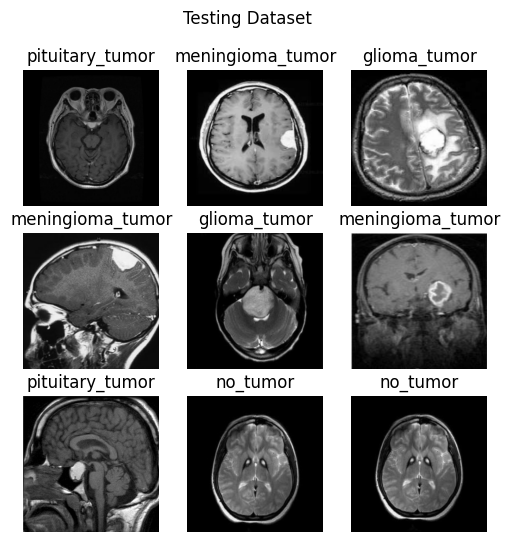

In [27]:
show_images(test_ds, 'Testing Dataset')

In [30]:
# convolutional neural network (CNN) model suitable for multi-class image classification with 4 output classes
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))) #Specifies the shape of the input images. Here, 3 indicates that the images are RGB (3 color channels).
#first convolutional layer applies 32 filters of size 3x3, using the ReLU activation function.
model.add(MaxPooling2D((2, 2))) #This layer downsamples the feature maps from the previous layer by taking the maximum value over a 2x2 window, reducing the spatial dimensions.
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten()) #Converts the 3D output from the final convolutional layer into a 1D vector, making it suitable for input into the dense layers.
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2)) #A dropout layer that randomly sets 20% of the inputs to 0 during training, which helps prevent overfitting.


model.add(Dense(4, activation='softmax')) # softmax activation function, which outputs a probability distribution across the classes


In [31]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), #Adam adjusts the learning rate during training. It combines the benefits of two other extensions of stochastic gradient descent, namely AdaGrad and RMSProp.
              loss='categorical_crossentropy', #loss function is suitable for multi-class classification problems where the classes are one-hot encoded. It measures the dissimilarity between the true labels and the predicted probabilities.
              metrics=['accuracy']) #indicates the proportion of correctly predicted instances over the total number of instances.

# Train the model
history = model.fit(train_generator,
                    epochs=EPOCHS,
                    validation_data=test_generator)
#After each epoch, the model will evaluate its performance on the test dataset using the test_generator

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 496s 5s/step - accuracy: 0.4224 - loss: 1.4451 - val_accuracy: 0.3782 - val_loss: 1.3329
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 489s 5s/step - accuracy: 0.6205 - loss: 0.9060 - val_accuracy: 0.4924 - val_loss: 1.3884
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 476s 5s/step - accuracy: 0.7114 - loss: 0.6692 - val_accuracy: 0.4822 - val_loss: 1.3295
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 472s 5s/step - accuracy: 0.7278 - loss: 0.6230 - val_accuracy: 0.4822 - val_loss: 1.6903
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 491s 5s/step - accuracy: 0.7736 - loss: 0.5566 - val_accuracy: 0.4391 - val_loss: 2.3439
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 506s 5s/step - accuracy: 0.7945 - loss: 0.5031 - val_accuracy: 0.5051 - val_loss: 2.6177
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 460s 5s/step - accuracy: 0.7955 - loss: 0.4655 - val_accuracy: 0.5736 - val_loss: 2.1655
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 507s 5s/step - accuracy: 0.8266 - loss: 0.4247 - val_accuracy: 0.6041 - v

In [33]:
# Evaluate the model
#test_loss:computed loss value for the test dataset, which indicates how well the model's predictions match the true labels.
#test_acc:accuracy metric calculated for the test dataset, representing the proportion of correct predictions
test_loss, test_acc = model.evaluate(test_generator) #computes the loss and accuracy of the model on the test dataset. It uses the same batch size defined earlier
print(f'Test accuracy: {test_acc:.2f}')



13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6526 - loss: 2.7443
Test accuracy: 0.62


In [34]:
# Use the model for predictions
predictions = model.predict(test_generator) #function generates predictions for all images in the test_generator. It returns an array of predicted probabilities for each class (in your case, 4 classes)

#np.argmax(predictions, axis=1):converts the predicted probabilities into class labels.
#argmax returns the index of the highest probability for each image, effectively assigning the predicted class.
predicted_classes = np.argmax(predictions, axis=1)


13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


In [35]:
# classification_report function from sklearn.metrics provides a detailed breakdown of the model's performance

print(classification_report(test_generator.classes, predicted_classes))

#confusion matrix shows how many predictions were correct and incorrect for each class
print(confusion_matrix(test_generator.classes, predicted_classes))


              precision    recall  f1-score   support

           0       0.37      0.07      0.12       100
           1       0.31      0.39      0.34       115
           2       0.22      0.38      0.28       105
           3       0.14      0.09      0.11        74

    accuracy                           0.25       394
   macro avg       0.26      0.23      0.21       394
weighted avg       0.27      0.25      0.23       394

[[ 7 30 46 17]
 [ 0 45 60 10]
 [ 9 40 40 16]
 [ 3 32 32  7]]


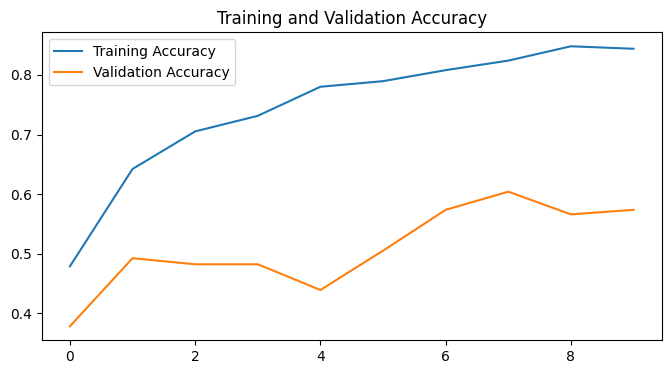

In [36]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

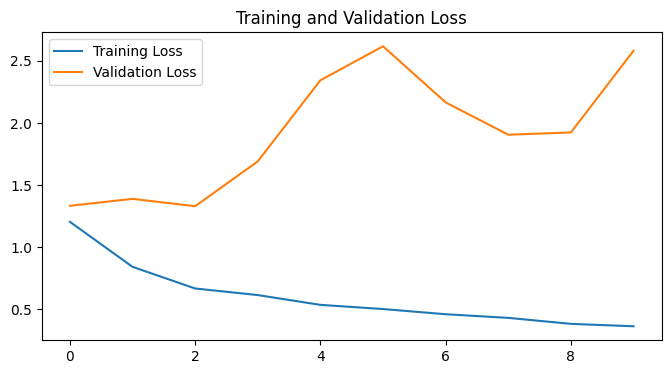

In [37]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [38]:
model.save('brain_tumor_model.h5')

In [40]:
# Load the saved model
# Import necessary modules
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('brain_tumor_model.h5')

In [52]:
# Load and preprocess the custom image
img_path = "/content/glioma.jpg"
img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

# Convert the image to array
img_array = image.img_to_array(img)

# Rescale pixel values (same as in training)
img_array = img_array / 255.0

# Expand dimensions to match the model's expected input shape (batchsize, height, width, channels)

img_array = img_array.reshape((1, IMG_HEIGHT, IMG_WIDTH, 3)) # Reshape to (1, 256, 256, 3)

# Make predictions
predictions = loaded_model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


In [53]:
# Decode the prediction (index to class label)
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Class labels in the same order as used during training
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Output the predicted class
predicted_class = class_labels[predicted_class_index]
print(f'Predicted class: {predicted_class}')

Predicted class: meningioma
